In [19]:
import numpy as np
import cv2
import torch 
import torchvision.transforms as T
from datasets import load_dataset
import matplotlib.pyplot as plt
from transformers import AutoImageProcessor, AutoModel

In [25]:
gamma1 = np.array([[5,1,2],[2,1,0],[2,5,2]])
gamma2 = np.array([[0,5,3],[0,2,1],[9,0,0]])
cost = np.array([[1,3,2],[3,2,2],[4,1,1]])
print('Gamma 1:')
print(gamma1)
print('Gamma 2:')
print(gamma2)
print('Cost:')
print(cost)
np.sum(np.multiply(gamma1,cost)), np.sum(np.multiply(gamma2,cost))

Gamma 1:
[[5 1 2]
 [2 1 0]
 [2 5 2]]
Gamma 2:
[[0 5 3]
 [0 2 1]
 [9 0 0]]
Cost:
[[1 3 2]
 [3 2 2]
 [4 1 1]]


(35, 63)

In [29]:
entropy = -np.sum(np.multiply(cost, np.log(cost)-1))
entropy

2.704265740152107

In [2]:
a = [1,2,3]
b = [1,2]
a[:2], b[:2]
iterator = iter(a)
next(iterator)

1

In [3]:
# Based on : https://gist.github.com/soruly/bd02a218690fe4e19295de3f5bede242
def compare(img1_path, img2_path):
    # Read in images
    img1, img2 = cv2.imread(img1_path), cv2.imread(img2_path)                
    # https://stackoverflow.com/questions/65541488/dead-kernel-sift-detectgray-none-the-kernel-appears-to-have-died-it-will-re
    # Using cv2.SIFT_create() to avoid kernel dying, like it does with cv2.SIFT()
    sift = cv2.SIFT_create() # Initializing SIFT

    # Detect keypoints and descriptors
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    # Match features between the two images
    bf = cv2.BFMatcher()
    matches = bf.match(des1,des2)
    return matches

# matches1 = compare('./data/test/dog1.jpg', './data/test/dog2.jpg')
# matches2 = compare('./data/test/cat1.jpg', './data/test/dog2.jpg')
# matches3 = compare('./data/test/cat1.jpg', './data/test/dog1.jpg')
# print(len(matches1), len(matches2), len(matches3))

In [4]:
# Based on: https://huggingface.co/blog/image-similarity
model_ckpt = 'google/vit-base-patch16-224-in21k'
processor = AutoImageProcessor.from_pretrained(model_ckpt)
model = AutoModel.from_pretrained(model_ckpt)

In [5]:
num_samples = 100
seed = 42
batch_size = 64
dataset = load_dataset("beans")
candidate_subset = dataset["train"].shuffle(seed=seed).select(range(num_samples))

In [17]:
# Data transformation chain.
transformation_chain = T.Compose(
    [
        # Resize the input image to 256x256, then take a center crop.
        T.Resize((processor.size['height'], processor.size['width'])),
        T.CenterCrop(processor.size["height"]),
        T.ToTensor(),
        T.Normalize(mean=processor.image_mean, std=processor.image_std),
    ]
)

def extract_embeddings(model: torch.nn.Module):
    """Utility to compute embeddings."""
    device = model.device

    def forward(batch):
        images = batch["image"]
        image_batch_transformed = torch.stack([transformation_chain(image) for image in images])
        new_batch = image_batch_transformed.to(device)
        print(new_batch.dtype)
        print(new_batch.shape)
        print(device)
        print(new_batch[0])
        with torch.no_grad():
            embeddings = model(new_batch).last_hidden_state[:, 0].cpu()
        return {"embeddings": embeddings, "transformed": image_batch_transformed}

    return forward


In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu"
extract_fn = extract_embeddings(model.to(device))
candidate_subset_emb = candidate_subset.map(extract_fn, batched=True, batch_size=batch_size)

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

torch.float32
torch.Size([64, 3, 224, 224])
cuda:0
tensor([[[-0.8353, -0.8431, -0.8510,  ..., -0.3569, -0.5294, -0.6549],
         [-0.8510, -0.8510, -0.8588,  ..., -0.4745, -0.6157, -0.7098],
         [-0.8510, -0.8510, -0.8510,  ..., -0.6000, -0.7098, -0.8510],
         ...,
         [-0.3333, -0.4431, -0.5529,  ..., -0.1765, -0.1686, -0.1608],
         [-0.6784, -0.7412, -0.7098,  ..., -0.2157, -0.2157, -0.2157],
         [-0.7804, -0.7647, -0.7176,  ..., -0.2157, -0.2235, -0.2078]],

        [[-0.6000, -0.6078, -0.6157,  ...,  0.1843, -0.0039, -0.1608],
         [-0.6157, -0.6235, -0.6235,  ...,  0.0431, -0.1608, -0.3176],
         [-0.6314, -0.6392, -0.6314,  ..., -0.1294, -0.3490, -0.5608],
         ...,
         [ 0.0824, -0.0353, -0.1451,  ..., -0.2314, -0.2471, -0.2471],
         [-0.2392, -0.3020, -0.2549,  ..., -0.2941, -0.3020, -0.2863],
         [-0.3020, -0.2863, -0.2392,  ..., -0.3020, -0.3020, -0.2784]],

        [[-0.8196, -0.8275, -0.8275,  ..., -0.8353, -0.9451, -1.0

In [8]:
arr = np.array(candidate_subset_emb["transformed"])

In [8]:
from tqdm import tqdm
candidate_ids = []

for id in tqdm(range(len(candidate_subset_emb))):
    label = candidate_subset_emb[id]["labels"]

    # Create a unique indentifier.
    entry = str(id) + "_" + str(label)

    candidate_ids.append(entry)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 229.14it/s]


In [9]:
all_candidate_embeddings = np.array(candidate_subset_emb["embeddings"])
all_candidate_embeddings = torch.from_numpy(all_candidate_embeddings)

In [10]:
def compute_scores(emb_one, emb_two):
    """Computes cosine similarity between two vectors."""
    scores = torch.nn.functional.cosine_similarity(emb_one, emb_two)
    return scores.numpy().tolist()


def fetch_similar(image, top_k=5):
    """Fetches the `top_k` similar images with `image` as the query."""
    # Prepare the input query image for embedding computation.
    image_transformed = transformation_chain(image).unsqueeze(0)
    new_batch = {"pixel_values": image_transformed.to(device)}

    # Comute the embedding.
    with torch.no_grad():
        query_embeddings = model(**new_batch).last_hidden_state[:, 0].cpu()

    # Compute similarity scores with all the candidate images at one go.
    # We also create a mapping between the candidate image identifiers
    # and their similarity scores with the query image.
    sim_scores = compute_scores(all_candidate_embeddings, query_embeddings)
    similarity_mapping = dict(zip(candidate_ids, sim_scores))
 
    # Sort the mapping dictionary and return `top_k` candidates.
    similarity_mapping_sorted = dict(
        sorted(similarity_mapping.items(), key=lambda x: x[1], reverse=True)
    )
    id_entries = list(similarity_mapping_sorted.keys())[:top_k]

    ids = list(map(lambda x: int(x.split("_")[0]), id_entries))
    labels = list(map(lambda x: int(x.split("_")[-1]), id_entries))
    return ids, labels

In [11]:
test_idx = np.random.choice(len(dataset["test"]))
test_sample = dataset["test"][test_idx]["image"]
test_label = dataset["test"][test_idx]["labels"]

sim_ids, sim_labels = fetch_similar(test_sample)
print(f"Query label: {test_label}")
print(f"Top 5 similar IDs: {sim_ids}")
sim_labels

Query label: 2
Top 5 candidate labels: [2, 2, 2, 2, 2]


In [13]:
labels = dataset["train"].features["labels"].names
label2id, id2label = dict(), dict()

for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

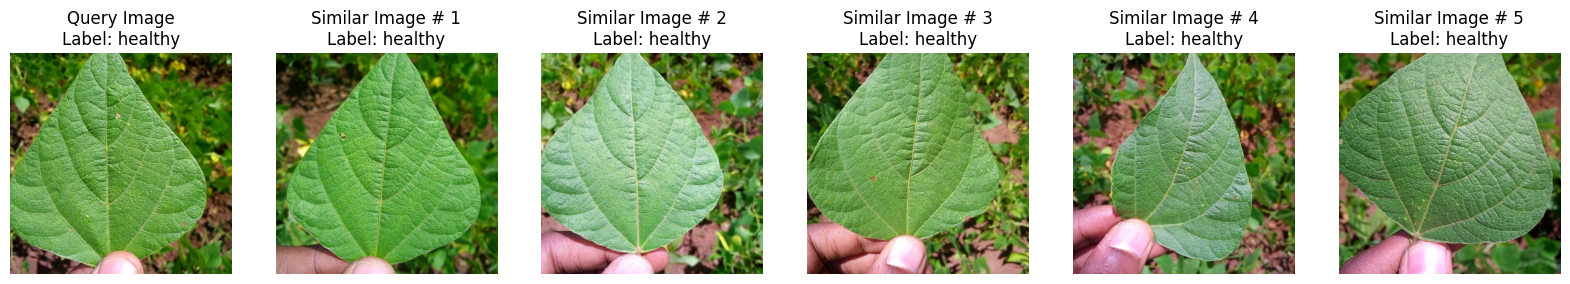

In [14]:
def plot_images(images, labels):
    if not isinstance(labels, list):
        labels = labels.tolist()

    plt.figure(figsize=(20, 10))
    columns = 6
    for (i, image) in enumerate(images):
        label_id = int(labels[i])
        ax = plt.subplot(int(len(images) / columns + 1), columns, i + 1)
        if i == 0:
            ax.set_title("Query Image\n" + "Label: {}".format(id2label[label_id]))
        else:
            ax.set_title(
                "Similar Image # " + str(i) + "\nLabel: {}".format(id2label[label_id])
            )
        plt.imshow(np.array(image).astype("int"))
        plt.axis("off")


images = []
labels = []

for id, label in zip(sim_ids, sim_labels):
    images.append(candidate_subset_emb[id]["image"])
    labels.append(candidate_subset_emb[id]["labels"])

images.insert(0, test_sample)
labels.insert(0, test_label)
plot_images(images, labels)